In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.impute import KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

#importing algorithms
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import sklearn
import shap
import optuna
import joblib

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/site-energy-intensity-dataset/y_test.csv
/kaggle/input/site-energy-intensity-dataset/x_test.csv
/kaggle/input/site-energy-intensity-dataset/train_dataset.csv


# Load the dataset

In [2]:
df = pd.read_csv("/kaggle/input/site-energy-intensity-dataset/train_dataset.csv")
test_df = pd.read_csv("/kaggle/input/site-energy-intensity-dataset/x_test.csv")
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


# Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [4]:
# columns with null values
df.isnull().sum()[df.isnull().sum() != 0]

year_built                    1837
energy_star_rating           26709
direction_max_wind_speed     41082
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
dtype: int64

In [5]:
# correlation matrix
df.corr().T

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
Year_Factor,1.000000,-0.036363,0.084143,-0.005052,0.132855,0.007913,-0.099628,-0.291137,-0.391312,-0.101799,...,0.185233,0.054718,-0.043701,-0.013635,0.231525,0.214651,0.233857,0.619227,-0.045179,0.534754
floor_area,-0.036363,1.000000,0.100878,0.034947,0.097797,-0.148467,-0.137654,-0.104118,-0.106110,-0.120068,...,0.049897,0.022583,-0.031415,-0.009205,-0.000018,-0.003984,-0.000922,0.014282,0.073967,-0.090856
year_built,0.084143,0.100878,1.000000,-0.073857,0.047803,-0.011210,-0.032846,-0.080230,-0.000619,-0.020201,...,-0.035519,-0.005065,-0.054164,NaN,0.001168,-0.009591,0.004945,0.084167,0.017162,0.053929
energy_star_rating,-0.005052,0.034947,-0.073857,1.000000,-0.016783,0.144452,0.149421,0.081703,0.126411,0.137479,...,-0.074993,0.019541,0.059382,NaN,-0.000992,0.002014,-0.000333,0.019387,-0.511012,-0.025448
ELEVATION,0.132855,0.097797,0.047803,-0.016783,1.000000,-0.255502,-0.233452,-0.345130,-0.153185,-0.184543,...,0.062014,0.184423,0.104934,0.077188,0.050804,0.074144,0.040172,0.495345,0.011798,-0.201664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
direction_peak_wind_speed,0.214651,-0.003984,-0.009591,0.002014,0.074144,-0.159938,-0.257252,-0.281605,-0.328404,-0.679818,...,0.467093,-0.027694,-0.026805,0.023397,0.999784,1.000000,0.992227,0.330064,0.013589,0.210752
max_wind_speed,0.233857,-0.000922,0.004945,-0.000333,0.040172,-0.162500,-0.271260,-0.302567,-0.349035,-0.694419,...,0.491481,-0.025128,-0.019491,0.018086,0.988797,0.992227,1.000000,0.353990,0.010639,0.218777
days_with_fog,0.619227,0.014282,0.084167,0.019387,0.495345,-0.035741,-0.108595,-0.321699,-0.286155,-0.173583,...,0.084892,0.048981,-0.207379,NaN,0.330441,0.330064,0.353990,1.000000,-0.055388,0.301534
site_eui,-0.045179,0.073967,0.017162,-0.511012,0.011798,-0.179190,-0.167982,-0.097070,-0.147348,-0.154071,...,0.086347,-0.007980,-0.050029,-0.014190,0.010217,0.013589,0.010639,-0.055388,1.000000,-0.026500


In [8]:
# Data description
df.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,...,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,...,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120,75756.000000


## Dataset obervations:

- 6 Columns are having missing values
- Energy intensity means usage of electricity and heat (The more the use, more the intensity of energy and CO2 emmissions per building)
- Bulding characteristics and energy usage over a period of year is given (Every Month's Min, Max and Mean)
- Samples are from various of states of USA
- Need to check relations between site conditions and usage of energy

<AxesSubplot:>

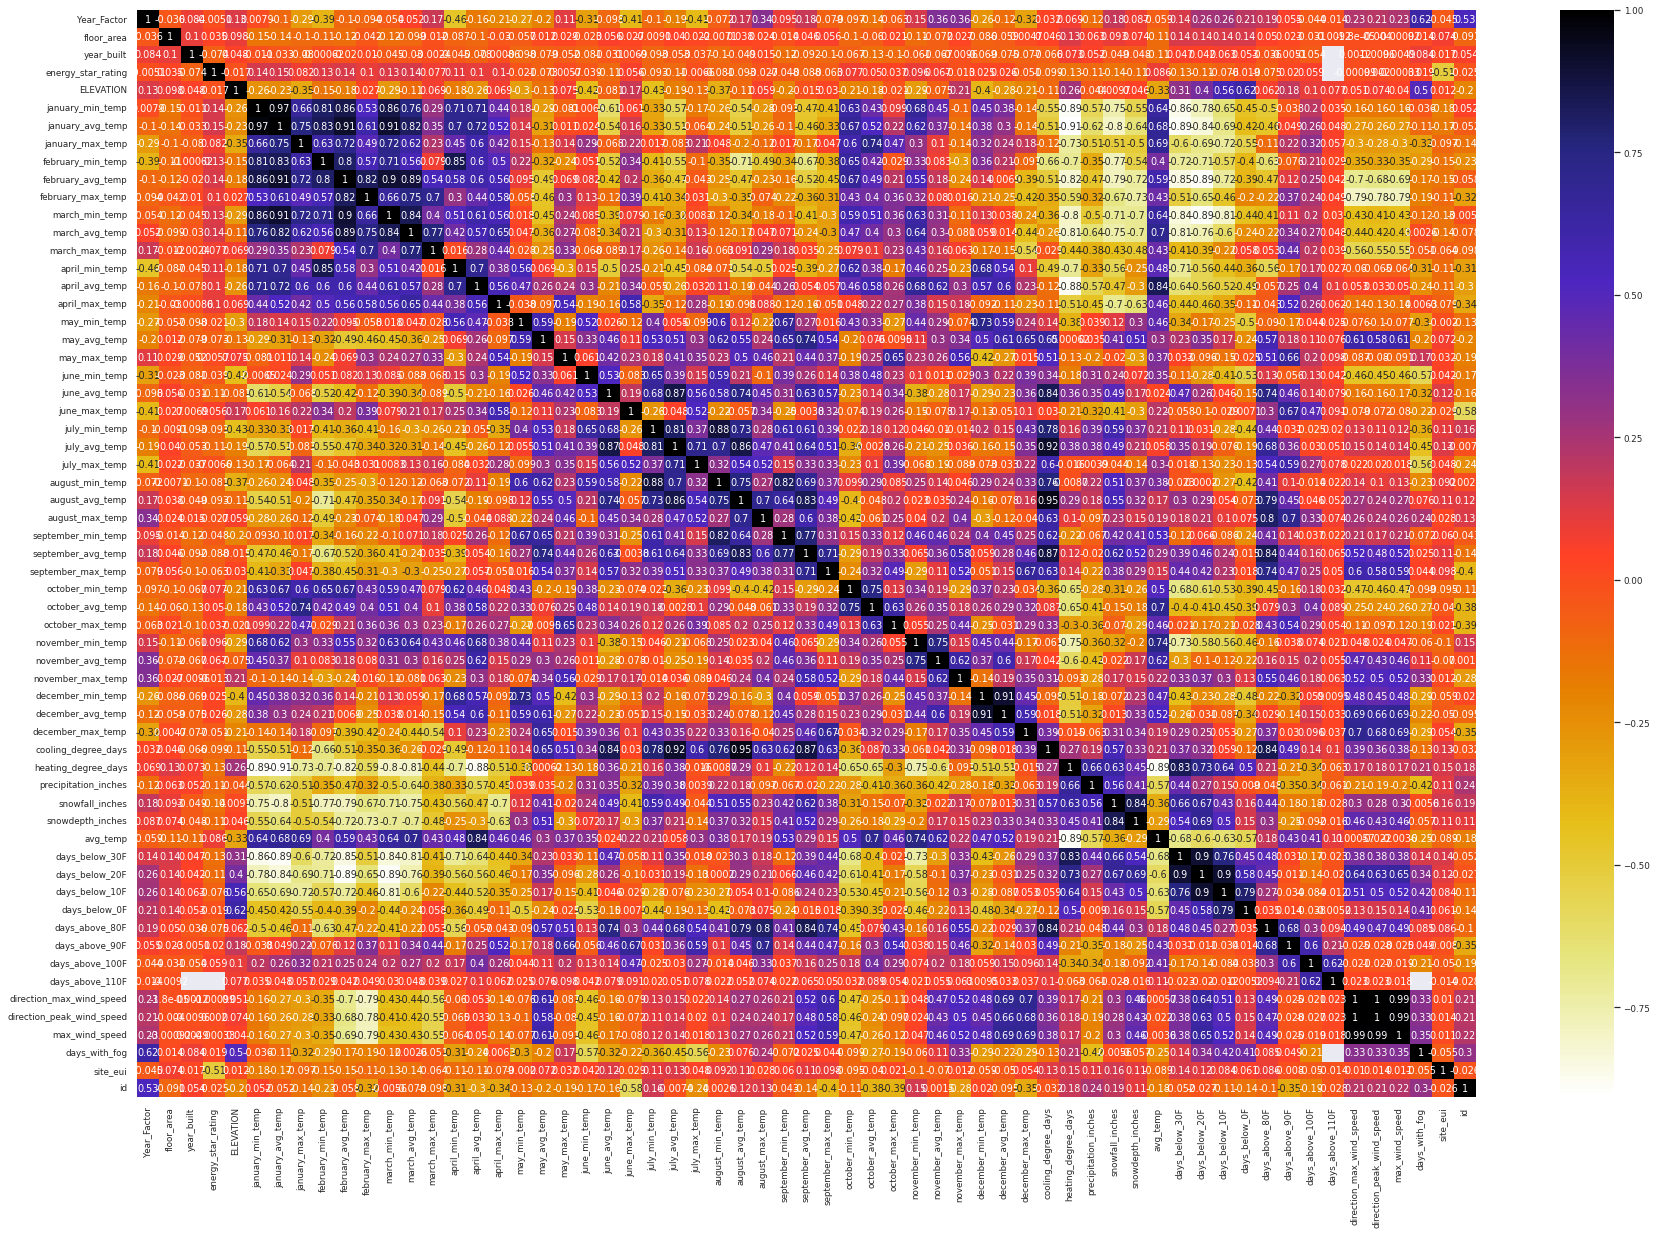

In [9]:
# heatmap to visualize multi collinearity in dataset
plt.figure(figsize=(30,20))
sns.set(font_scale=0.8)
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)

- Dataset has multiple columns inter correlations which is not good for regression problem
- Temperature columns during winter, summer months correlate with each other

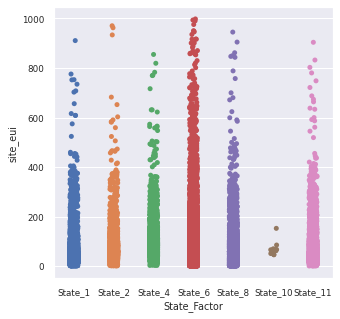

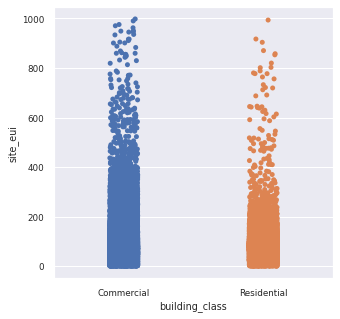

In [10]:
# bivariate analysis 
obj_cols = ['State_Factor','building_class']

for col in obj_cols:
    plt.figure(figsize=(5,5))
    sns.stripplot(x=col, y='site_eui', data=df)
    plt.show()

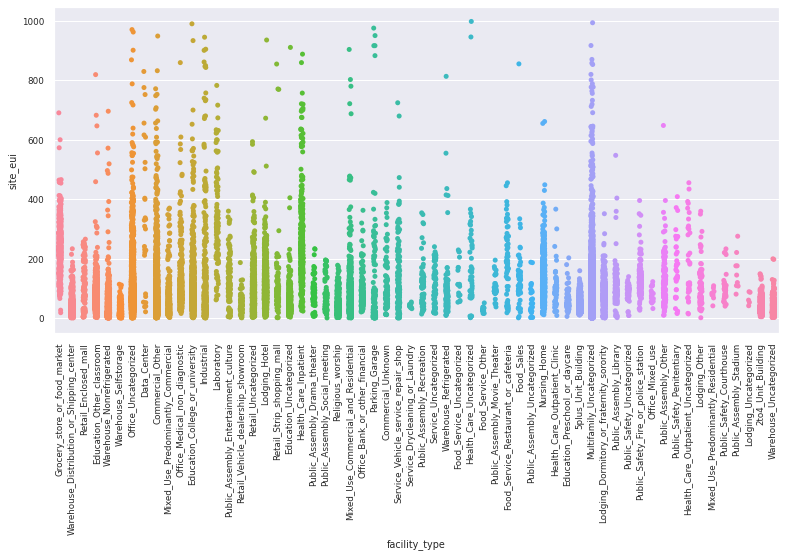

In [11]:
plt.figure(figsize=(13,6))
sns.stripplot(x='facility_type', y='site_eui', data=df)
plt.xticks(rotation=90)
plt.show()

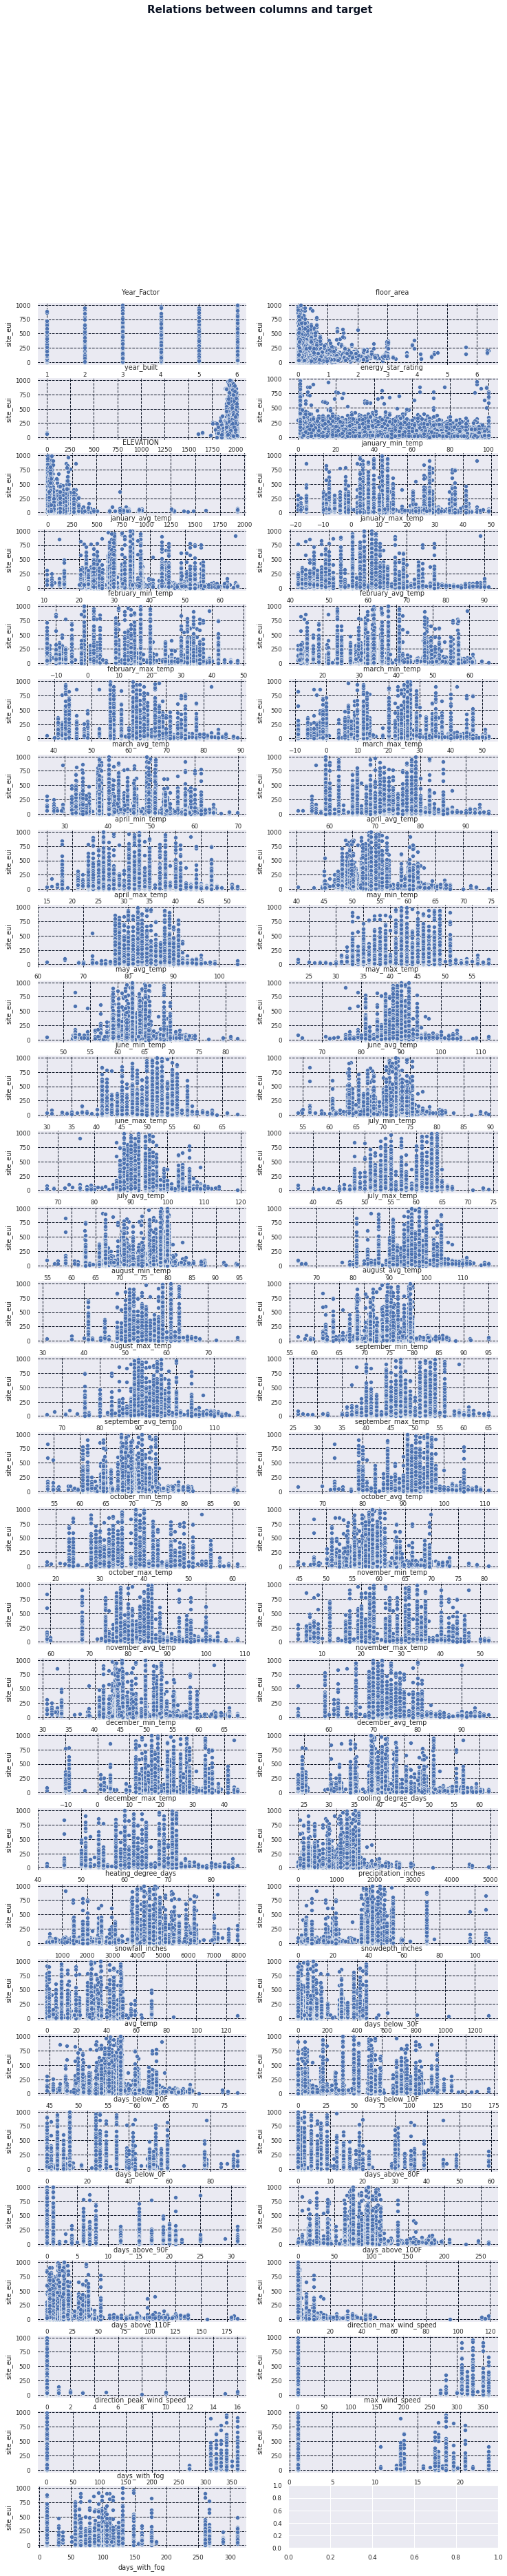

In [12]:
ndf = df.drop(['id','site_eui'], axis=1)
target = df['site_eui']

col_list = [col for col in ndf.columns if ndf[col].dtype != 'object']

fig, ax = plt.subplots(30,2, figsize=(12,60))
for idx, col in enumerate(col_list):
    sns.scatterplot(x=col, y='site_eui', data=df, ax=ax[idx//2, idx%2])
    ax[idx//2, idx%2].grid(visible=True, linestyle='--', color='#0b1324')
    ax[idx//2, idx%2].set_title(f'{col} ', pad=12)
    
plt.suptitle(f'Relations between columns and target', fontsize=15, fontweight='bold',
            color='#0b1324')
plt.show()

## Notes:

- 'ELEVATION' column has relation with target column
- There's no significant correlation between dependent columns and target column 
- Year factor and Year built columns do relate with target columns, we will drop them.
- 'days_with_fog' will be filled with knnimputer and other 3 columns with 'mode' value as most of the values are 1
- 'Energy star rating' filling using mean values as it relates to target variable
- For categorical columns, we will remove 'Facility type' column to avoid high dimensionality and noise.
- We will remove 'Days with above 110F' column

# Data preparation and pre-processing

## Handling missing values

In [13]:
# last 4 columns are having more than 50% of the missing values
(ndf.isnull().sum()[ndf.isnull().sum() != 0]/len(target))*100

year_built                    2.424858
energy_star_rating           35.256148
direction_max_wind_speed     54.228652
direction_peak_wind_speed    55.190939
max_wind_speed               54.228652
days_with_fog                60.451179
dtype: float64

In [14]:
# remove noisy features
remove_col = ['Year_Factor','facility_type','year_built','days_above_110F']
n_df = ndf.drop(columns=remove_col, axis=1)

# fill the missing values of the columns
n_df['energy_star_rating'] = n_df['energy_star_rating'].fillna(n_df['energy_star_rating'].mean())
n_df['direction_max_wind_speed'] = n_df['direction_max_wind_speed'].fillna(1.0)
n_df['direction_peak_wind_speed'] = n_df['direction_peak_wind_speed'].fillna(1.0)
n_df['max_wind_speed'] = n_df['max_wind_speed'].fillna(1.0)

In [15]:
# handle missing values in fog column
n_df['days_with_fog'] = n_df['days_with_fog'].fillna(n_df['days_with_fog'].mean())

In [16]:
n_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   State_Factor               75757 non-null  object 
 1   building_class             75757 non-null  object 
 2   floor_area                 75757 non-null  float64
 3   energy_star_rating         75757 non-null  float64
 4   ELEVATION                  75757 non-null  float64
 5   january_min_temp           75757 non-null  int64  
 6   january_avg_temp           75757 non-null  float64
 7   january_max_temp           75757 non-null  int64  
 8   february_min_temp          75757 non-null  int64  
 9   february_avg_temp          75757 non-null  float64
 10  february_max_temp          75757 non-null  int64  
 11  march_min_temp             75757 non-null  int64  
 12  march_avg_temp             75757 non-null  float64
 13  march_max_temp             75757 non-null  int

## Treating Multicollinearity

In [17]:
# VIF calculations (refer: Dinesh Kumar's Book)
def get_vif(X):
    X_matrix = np.array(X)
    vif = [variance_inflation_factor(X_matrix, i) for i in range(X_matrix.shape[1])]
    vif_factors =  pd.DataFrame()
    vif_factors['columns'] = X.columns
    vif_factors['VIF'] = vif
    return vif_factors

X = n_df.drop(columns=['State_Factor','building_class'], axis=1)
vif_factors = get_vif(X)
vif_factors

,columns,VIF
0,floor_area,1.547030e+00
1,energy_star_rating,8.200782e+00
2,ELEVATION,3.746789e+00
3,january_min_temp,1.337788e+03
4,january_avg_temp,1.730464e+05
5,january_max_temp,2.674410e+04
6,february_min_temp,1.318597e+03
7,february_avg_temp,1.202394e+05
8,february_max_temp,1.674008e+04
9,march_min_temp,5.387635e+03


In [ ]:
# total 56 columns
vif_factors.info()

In [ ]:
# find the columns with large VIF (vif > 4)
cols_with_large_vif = vif_factors[vif_factors.VIF > 4]['columns']
cols_with_large_vif

- Total columns are 56
- Total of 55 columns are having VIF higher than 4 which is great sign of multi multicollinearity
- let's plot heat map of highly collinear columns to remove them

In [ ]:
mc_df = n_df[list(cols_with_large_vif)]
plt.figure(figsize=(30,20))
sns.set(font_scale=0.8)
sns.heatmap(mc_df.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

- It is clear that winter and summer months cols are highly correlated

### Feature engineering strategy

- Take mean of 'min', 'max' and 'avg' columns of Oct-April months and remove individual months' cols
- Take mean of 'min', 'max' and 'avg' columns of May-Sept months and remove induvidual months' cols
- Average of days below 30F columns adn remove individual cols
- Remove Direction max and peak columns to avoid MC
- Remove Snowfalldepth inches, avg_temp and days_above_90F

## Feature engineering

In [ ]:
# Summetion of seasonal (i.e. winter and summer) columns  to reduce columns and MC
n_df['Avg_min_temp_winter'] = (n_df['january_min_temp'] + n_df['february_min_temp'] + n_df['march_min_temp'] + 
                               n_df['april_min_temp'] + n_df['october_min_temp'] + n_df['november_min_temp'] + n_df['december_min_temp'])/7

n_df['Avg_max_temp_winter'] = (n_df['january_max_temp'] + n_df['february_max_temp'] + n_df['march_max_temp'] + 
                               n_df['april_max_temp'] + n_df['october_max_temp'] + n_df['november_max_temp'] + n_df['december_max_temp'])/7

n_df['Avg_temp_winter'] = (n_df['january_avg_temp'] + n_df['february_avg_temp'] + n_df['march_avg_temp'] + 
                               n_df['april_avg_temp'] + n_df['october_avg_temp'] + n_df['november_avg_temp'] + n_df['december_avg_temp'])/7

In [ ]:
n_df['Avg_min_temp_summer'] = (n_df['may_min_temp'] + n_df['june_min_temp'] + n_df['july_min_temp'] + n_df['august_min_temp'] + n_df['september_min_temp'])/5 
n_df['Avg_max_temp_summer'] = (n_df['may_max_temp'] + n_df['june_max_temp'] + n_df['july_max_temp'] + n_df['august_max_temp'] + n_df['september_max_temp'])/5
n_df['Avg_temp_summer'] = (n_df['may_avg_temp'] + n_df['june_avg_temp'] + n_df['july_avg_temp'] + n_df['august_avg_temp'] + n_df['september_avg_temp'])/5 

In [ ]:
n_df['Avg_days_below30F'] = (n_df['days_below_30F'] + n_df['days_below_20F'] + n_df['days_below_10F'] + n_df['days_below_0F'])/4

### Remove unnecessary cols

In [ ]:
# columns to remove from the datset
months_cols = list(n_df.iloc[:,5:41].columns) + ['days_below_30F','days_below_20F','days_below_10F','days_below_0F','direction_max_wind_speed',
                                                'direction_peak_wind_speed','snowdepth_inches','avg_temp','days_above_90F']
xdf = n_df.drop(columns=months_cols, axis=1)
xdf.info()

In [ ]:
# check VIFs of new dataset
zdf = xdf.drop(columns=['State_Factor','building_class'], axis=1)
vif_factors2  = get_vif(zdf)
vif_factors2

In [ ]:
cols_with_large_vif2 = vif_factors2[vif_factors2.VIF > 4]['columns']
cols_with_large_vif2

In [ ]:
mc_df2 = zdf[list(cols_with_large_vif2)]
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
sns.heatmap(mc_df2.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

# Modeling baseline

In [ ]:
# zdf and target are the final dataset for time being for baseline modelling

X_train, X_val, y_train, y_val = train_test_split(zdf, target, test_size=0.3, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

In [ ]:
# modelling function for xgb and rf
def modeling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBRegressor()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [np.sqrt(mean_squared_error(y_test, y_pred))]
        models.append(xgb)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestRegressor(n_estimators=200, max_depth=8)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [np.sqrt(mean_squared_error(y_test, y_pred))]
        models.append(rf)
        
    return scores

In [ ]:
modeling(X_train, y_train, X_val, y_val, xgb=True, rf=True)

# Hyperparameter Tuning

In [ ]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

# A parameter grid for random forest
params = {
    'n_estimators': range(100, 200, 100),
    'ccp_alpha': [0.0, 0.1],
    'criterion': ['squared_error'],
    'max_depth': [5,6],
    'min_samples_split': [2,3,5],
}

rf_estimator = RandomForestRegressor()

gsearch = GridSearchCV(
    estimator= rf_estimator,
    param_grid= params,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=gkf,
    verbose=1,
)

rf_model = gsearch.fit(X=X_train, y=y_train)
(gsearch.best_params_, gsearch.best_score_)

In [ ]:
# A parameter grid for XGB regressors 
params_list = {
    'n_estimators': range(100, 300, 100),
    'reg_alpha': [0.0, 0.1,0.5],
    'eval_metric ': ['mean_squared_error'],
    'max_depth': [5,6],
    'learning_rate': [0.01,0.5,0.1]
}

xgb_estimator = XGBRegressor(n_estimators=900,
                            reg_alpha=0.5,
                            max_depth=10,
                            learning_rate=0.1
                            )

xgb_estimator.fit(X_train,y_train)
y_preds = xgb_estimator.predict(X_val)
score_rmse = np.sqrt(mean_squared_error(y_val, y_preds))
score_rmse

In [ ]:
xgb_estimator.save_model("site_eui_model.json")

In [ ]:
#xgb_estimator.save_model("site_eui_model2.json")

In [ ]:
# model2 = xgboost.XGBRegressor()
# model = model2.load_model("/kaggle/working/site_eui_model.json")

In [ ]:
#model = joblib.load("/kaggle/working/eui_model.joblib")

In [ ]:
X_train.describe()

In [ ]:
joblib.dump(xgb_estimator, "eui_model.joblib")

In [ ]:
pd.Series(xgb_estimator.predict(X_val)).sort_values(ascending=False)

# Explainable AI with SHAP

In [ ]:
shap.initjs()

In [ ]:
sample_set = X_val.sample(100)

In [ ]:
# shap values
shap_values = shap.TreeExplainer(xgb_estimator).shap_values(sample_set)

In [ ]:
shap.summary_plot(shap_values, sample_set, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, sample_set)

In [ ]:
shap.dependence_plot('energy_star_rating', shap_values, sample_set)

In [ ]:
shap.decision_plot(shap.TreeExplainer(xgb_estimator).expected_value[0], 
                   shap_values[50:100], 
                   feature_names=sample_set.columns.tolist()
                  )

# Optuna Hyperameter Tuning

In [ ]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def xgb_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "reg_alpha": trial.suggest_int("reg_alpha",  0.1, 0.5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1)
    }
     
    model = XGBRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [ ]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [ ]:
%%time
xgb_param, xgb_score = tuner(xgb_objective,1)
xgb_tuned_model = XGBRegressor(**xgb_param)

In [ ]:
# train model on tuned parameters to evalute on test/validation dataset
xgb_tuned_model.fit(X_train, y_train)

In [ ]:
y_tuned_preds = xgb_tuned_model.predict(X_val)

plt.figure(figsize = (7,5))
sns.distplot(y_val - y_tuned_preds)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

In [ ]:
# evaluation on test dataset
score_rmse2 = np.sqrt(mean_squared_error(y_val, y_tuned_preds))
score_rmse2

## Final conclusions:

- Optuna Tuned hyperparameters do increase significant RMSE score
- Explainable AI using SHAP depicts that energy star rating and floor area are among the top most important features among all the features available in dataset.
- Tuned XGB gave RMSE score of 46 which is better score than optuna hyper parameter tuning